In [2]:
if (!require(survRM2)) install.packages('survRM2')
library('survRM2') 
if (!require(mvtnorm)) install.packages('mvtnorm')
library('mvtnorm')
if (!require(survival)) install.packages('survival')
library('survival')
if (!require(nph)) install.packages('nph')
library('nph')
if (!require(foreach)) install.packages("foreach")
library('foreach') 
if (!require(doParallel)) install.packages("doParallel")
library('doParallel')
if (!require(ggplot2)) install.packages("ggplot2")
library('ggplot2')
if (!require(cowplot)) install.packages("cowplot")
library('cowplot')
library('IRdisplay')

n_cores <- detectCores()
cluster <- makeCluster(16) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('/home/r27user6/RMST_Code/Function.R')
clusterExport(cluster, "expo_gen_2stages")


## Theoretical RMST ($\tau = 1$). No censoring

In [64]:
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916

RMST_RSDST(lambda = lambda_H0, tau = 1)   # detail in Function file
RMST_RSDST(lambda = lambda_H1, tau = 1)

RMST,RSDST
<dbl>,<dbl>
0.4971488,0.1220925


RMST,RSDST
<dbl>,<dbl>
0.6548949,0.1273978


### RMST Estimation with censoring in interim 1 year

RMST of Control arm is: 0.495229 
Variance of RMST estimation of Control arm is: 2.732952e-05 
RMST of Experiment arm is: 0.6448322 
Variance of RMST estimation of Experiment arm is: 2.831875e-05

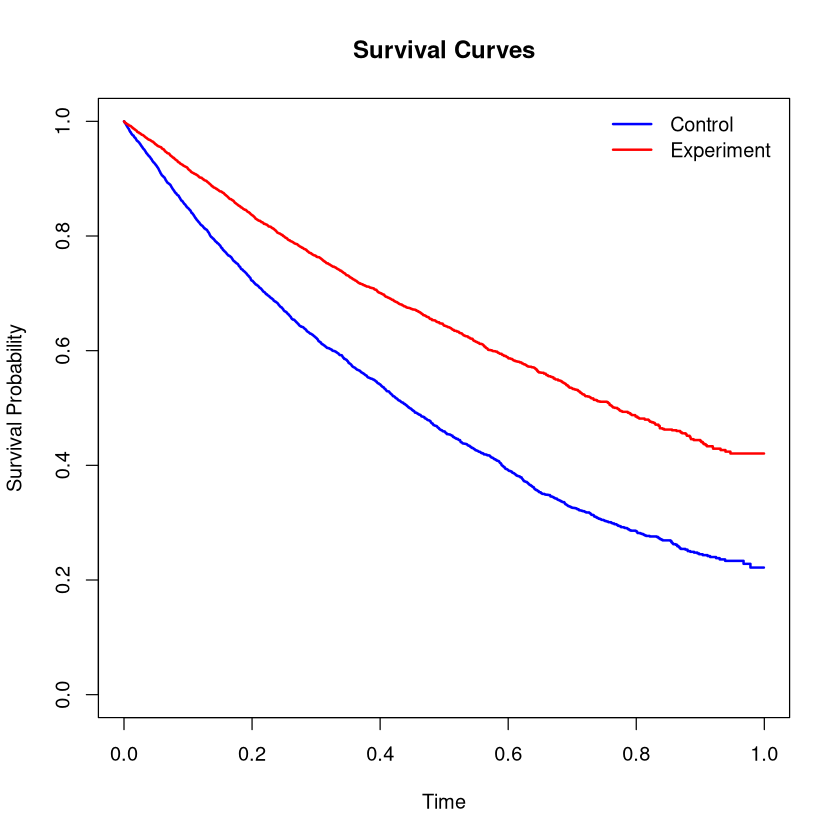

In [65]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(2,3,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(2,3,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_int <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 0.96)

cat('RMST of Control arm is:',rmst_result_int$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_int$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_int$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_int$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

### RMST Estimation with censoring in the whole study

RMST of Control arm is: 0.4923799 
Variance of RMST estimation of Control arm is: 1.212278e-05 
RMST of Experiment arm is: 0.6585054 
Variance of RMST estimation of Experiment arm is: 1.264252e-05

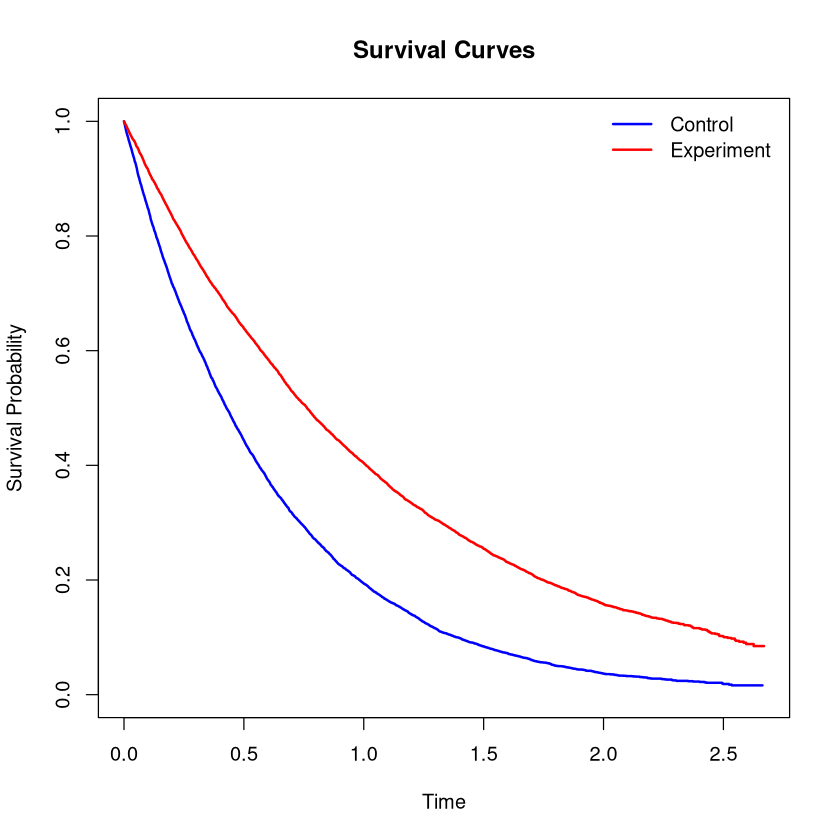

In [66]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(4,5,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(4,5,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_all <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 1)

cat('RMST of Control arm is:',rmst_result_all$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_all$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_all$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_all$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

# Prob of Early Termination by Normal integral:

### Use the normality of RMST to calculate the Prob of Early terminaton
####  $\textcolor{lightgreen}{P(E(\tau_1) - C(\tau_1) > m1\ \&\  E(\tau_1) > t1\ |H_0)}$
#### $(E-C,E)$ is bivariate normal. $E$ and $C$ are independent.
#### The covariance matrix $\Sigma$ of $(E-C, E)$ can be easily obtained
#### We set $m_1 = 0, t_1 = 0.3$ here 

In [67]:
mu_c <- rmst_result_int$RMST.arm0$rmst[1]
mu_e <- rmst_result_int$RMST.arm1$rmst[1]
var_c <- rmst_result_int$RMST.arm0$rmst.var
var_e <- rmst_result_int$RMST.arm1$rmst.var

mu_h0 <- c(0, mu_c)
sigma_h0 <- matrix(c(2*var_c, var_c, var_c, var_c), nrow = 2)
mu_h1 <- c(mu_e-mu_c, mu_e)
sigma_h1 <- matrix(c(var_e+var_c, var_e, var_e, var_c), nrow = 2)
upper <- c(Inf, Inf)

lower <- c(-0,0.3)
p_rj_h0 <- 1 - pmvnorm(lower, upper, mean = mu_h0, sigma = sigma_h0) # p(E-C>m1 & E>t1|H0)
p_rj_h1 <- 1 - pmvnorm(lower, upper, mean = mu_h1, sigma = sigma_h1)
cat(' PET0 =',p_rj_h0,'\n','PET1 =',p_rj_h1)

 PET0 = 0.5 
 PET1 = 0

### 10000 simulation (Same setting as Jung 2017)

In [62]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
set.seed(2024)
n1 <- 31 
m1 <- 0
t1 <- 0.3

# Use the data in interim period
data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                         cen_time = cen_time,arm = 0, interim = interim)
                        
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                        cen_time = cen_time,arm = 1, interim = interim)
                           
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                         cen_time = cen_time,arm = 1, interim = interim)
                             
rmst_h0 <- RMST_sim_cal(n = n1,data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                        tau = 2,sim_size = sim_size)
rmst_h1 <- RMST_sim_cal(n = n1,data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                        tau = 2,sim_size = sim_size)

proc_h0 <- sum((rmst_h0[2, ] - rmst_h0[1, ] > m1) & (rmst_h0[2, ] > t1))
proc_h1 <- sum((rmst_h1[2, ] - rmst_h1[1, ] > m1) & (rmst_h1[2, ] > t1))

cat(' Empirical PET0 =', 1-proc_h0/sim_size,'\n', 'Empirical PET1 = ',1-proc_h1/sim_size)

 Empirical PET0 = 0.5039 
 Empirical PET1 =  0.0415

## <span style="color:yellow"> We can use the normal integral to calculate the PET!!!

------

# 2 stages Experiment

#### Setting: acc_time = 1.67, cen_time = 1, interim $\tau_1 = 1$
####  $\textcolor{lightgreen}{H_0 : \lambda_0 = \lambda_1 = 1.609}$    
####  $\textcolor{lightgreen}{H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916}$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   
#### censoring dist in interim: $\tilde{C_i} \sim U[0,\tau_1]$.  After interim: $C_i \sim U[b=1,a+b=2.67]$

### <span style="color:yellow"> find_m_t_RMST is a self-defined function loop to find best m1, m2, t1, t2 in a certain dataset

In [68]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
interim <- 1
set.seed(2024)
n <- 51 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)                             

data_C_int <- data_C[ , c(2,3,1)]  # In the order of (obs_time, event, arm) for RMST test
data_E_H0_int <- data_E_H0[ , c(2,3,1)]
data_E_H1_int <- data_E_H1[ , c(2,3,1)]
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0_int, data_C = data_C_int,tau = interim,sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1_int, data_C = data_C_int,tau = interim,sim_size = sim_size)

data_C_fin <- data_C[ , c(4,5,1)]
data_E_H0_fin <- data_E_H0[ , c(4,5,1)]
data_E_H1_fin <- data_E_H1[ , c(4,5,1)]
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)
rmst_data

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.9991,result.9992,result.9993,result.9994,result.9995,result.9996,result.9997,result.9998,result.9999,result.10000
Est.,0.4616387,0.3736174,0.6169002,0.3625404,0.5355188,0.3899737,0.3339121,0.3970688,0.4743480,0.3708899,⋯,0.4180575,0.4422543,0.3762314,0.5296417,0.4610486,0.4820392,0.4568159,0.4610670,0.4348702,0.4332204
Est.,0.3706492,0.4447116,0.3849457,0.3273031,0.5644530,0.4180723,0.4878835,0.4186774,0.4234480,0.3361914,⋯,0.4236201,0.5695868,0.4954592,0.4965042,0.3320582,0.4249052,0.6321194,0.4291153,0.4663578,0.4696596
Est.,0.5619584,0.3736174,0.6169002,0.4039705,0.5396871,0.3915336,0.3390840,0.3970688,0.4605670,0.4767565,⋯,0.4180575,0.4422543,0.3886753,0.5296417,0.4610486,0.4820392,0.4568159,0.4317754,0.4158540,0.4332204
Est.,0.7238070,0.6386701,0.5191336,0.5136691,0.6032980,0.6112982,0.5882334,0.4221351,0.5289753,0.6720321,⋯,0.6168375,0.4938973,0.6948237,0.6096146,0.6804654,0.4853804,0.5566388,0.5397643,0.5281317,0.5926498
Est.,0.6115517,0.6673074,0.7199041,0.4841517,0.5231542,0.4587852,0.4126436,0.4754813,0.5124411,0.5662176,⋯,0.5288082,0.6011687,0.5806194,0.5937179,0.7562331,0.6779116,0.4834695,0.5261360,0.5918649,0.6120802
Est.,0.5477245,0.5605918,0.4179400,0.5594733,0.6531194,0.5960783,0.4711281,0.5678984,0.5866827,0.5793895,⋯,0.5772392,0.7358005,0.6228952,0.7150975,0.5900429,0.5256665,0.6332557,0.5271894,0.6271555,0.6434596
Est.,0.6273110,0.6673074,0.7060189,0.4841517,0.5231542,0.4587852,0.4126436,0.4754813,0.5124411,0.5599928,⋯,0.5442750,0.6011687,0.5595413,0.5937179,0.7562331,0.6779116,0.4834695,0.5261360,0.5918649,0.6120802
Est.,0.8883055,0.9373438,0.8492752,0.9246320,0.9341798,1.0036391,0.8724646,0.9845538,0.9574751,0.7785893,⋯,0.9902626,0.9319280,0.9239901,0.9372687,0.9392483,0.6994680,0.7030884,0.9517348,0.8096355,0.8528748


### Stage I : process to stage II when:  
####  $\textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_1) > t_1}$
#### Search for a suitable $m_1, t_1$ .m1 from -0.5 to 0.5, t1 from 0 to 1

### Stage II:
#### reject $H_1$ when:  
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2}$

### <span style="color:yellow"> Search for the best parameter combination to get as higher power as possible

### <font color=LightSeaGreen>We don't need to set a strict tar_a1(stage I type I error) since it may lose the overall power
### Loosen tar_a1 will lose PET0, but each time we are looking for the most powerful stage I setting.
### Since the overall rejection region contains the stage I rejection region. They both rise 

In [69]:
find_m_t_RMST(m_low = -0.5, t_low = 0, t_up = 1, rmst_data = rmst_data, search_times = 1000, search_step = 0.001,
         tar_a1 = 0.8, tar_pow1_low = 0.2, tar_a2 = 0.1, sim_size = 10000)

m1,t1,PET0,PET1,m2,t2,alpha,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.179,0.401,0.2005,0.005,-0.071,0.695,0.0998,0.9849


### In Jung (2017) p648 : $PET_0 = 0.2\ ,\  PET_1 = 0.41\ ,\ power = 0.9$

-----

## Log rank test for 2 stages to find the best critical value
### <span style="color:yellow"> find_m_logrank is similar to find_m_t_RMST. 

#### During the interim, process to stage II when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1}$, where $W_1\ ,\ \sigma_1$ are log rank test statistics and its variance in interim period
#### Reject H1 final stage when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \& \ \frac{W}{\sigma}>m_2}$

In [70]:
z_stats_h0_int <- log_rank_sim(data_C = data_C_int, data_E = data_E_H0_int, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C_int, data_E = data_E_H1_int, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)
logrank_data 

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.9991,result.9992,result.9993,result.9994,result.9995,result.9996,result.9997,result.9998,result.9999,result.10000
z_stats_h0_int,-1.2872474,1.112123,-2.1856323,-0.4871775,0.3551447,0.2459673,1.6505821,0.2404881,-0.6236618,-0.6377972,⋯,0.4123125,1.4529391,1.1189202,-0.3584861,-0.9876944,-0.3656003,1.117835,-0.19184269,0.2899575,0.3219920
z_stats_h1_int,1.6470271,3.168536,-0.9422678,1.3230336,0.7968894,2.4742329,2.9627174,0.2666048,0.5181259,1.6724925,⋯,2.2976298,0.5973465,2.3315186,0.8112787,2.3312606,0.1724213,1.105871,1.32263295,1.0234962,2.2295654
z_stats_h0_fin,-0.6928428,-1.068716,-2.8305862,0.3613341,1.2141556,1.7793817,0.7754382,0.8505837,0.7242671,0.2193938,⋯,0.5205964,0.9144868,0.4587114,1.2737350,-1.1215383,-1.3841143,2.033960,-0.05981692,0.3443267,0.3460273
z_stats_h1_fin,2.0152389,2.221934,1.0692737,3.3243011,2.8097983,4.8082256,4.3281383,3.4476979,3.2569595,2.2602944,⋯,3.5399141,2.4835404,2.8392669,3.0335143,1.3214492,0.2049053,2.928037,3.08091001,1.9971216,2.0482152


In [71]:
find_m_logrank(m_low = -3, logrank_data = logrank_data, search_times = 5000, search_step = 0.001,
                tar_a1 = 0.8, tar_pow1_low = 0.1, tar_a2 = 0.1, sim_size = 10000)

m1,PET0,PET1,m2,alpha,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.844,0.2001,0.0127,1.274,0.0998,0.9046


### Conduct a log rank test at the end of the 2 stages trial. Interim $\tau = 1$ year  
### <span style="color:yellow">The power is exactly the same as 2 stages log rank design


In [72]:
# Empirical alpha
log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection
# Empirical power
log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection                          

[1] 0.0999

[1] 0.9098

### Some experiments in Jung 2017 p650 table 1. Stop for futility only.
#### Optimal: $\lambda_2=0.9,\lambda_1 = \lambda_2*\Delta,n = 187, n_1 = 95, \alpha = 0.05, 1-\beta = 0.8$
#### $PET_0 = 0.556, PET_1 = 0.104$

In [56]:
sim_size <- 10000 
acc_time <- 174 / 60
cen_time <- 1
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
interim <- 112 / 60
set.seed(2024)
n <- ceiling(174/2)  #sample size per arm 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)                             

z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)
logrank_data 


,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.9991,result.9992,result.9993,result.9994,result.9995,result.9996,result.9997,result.9998,result.9999,result.10000
z_stats_h0_int,-0.1647918,-0.5158049,2.268464,1.033609,0.6152101,1.400449,-0.4414484,-0.04036954,-1.1646784,1.067536,⋯,1.222531,-0.516138655,-1.15552638,1.0690183,0.3605924,-0.3881763,1.534777,-0.4148307,1.3009078,-0.4480364
z_stats_h1_int,2.2058519,0.4284476,4.564531,2.194423,0.2038618,1.870154,1.4374685,1.42344517,-0.4184514,1.265772,⋯,2.061019,0.789762773,-0.01113722,3.4627403,1.8042203,1.5665803,3.478268,1.4418160,2.8956319,0.4037078
z_stats_h0_fin,0.5215533,-0.6142791,2.100829,1.383711,2.1323474,1.024938,-0.2651750,-0.24156671,0.2257347,-0.605476,⋯,1.110650,-0.009000053,0.39706748,0.2308607,0.5266994,-0.0608201,1.311645,-0.1577494,0.7749838,-1.8764533
z_stats_h1_fin,3.4363802,1.8087747,4.830229,3.550426,1.3132939,2.828324,2.7535275,2.15831330,0.8887442,1.293711,⋯,3.147644,0.597907585,2.00592053,3.4342356,3.2229485,2.0954422,3.894014,2.3005270,2.5853687,2.0764274


### Use the cut off point in Jung's paper

In [57]:
m1 <- -0.32
m2 <- 1.641
#PET0
1 - sum(z_stats_h0_int > m1)/sim_size
#PET1
1 - sum(z_stats_h1_int > m1)/sim_size
#alpha
sum((logrank_data[1, ] > m1) & (logrank_data[3, ]  > m2))/sim_size
#power 
sum((logrank_data[2, ] > m1) & (logrank_data[4, ]  > m2))/sim_size

[1] 0.379

[1] 0.028

[1] 0.0505

[1] 0.8028

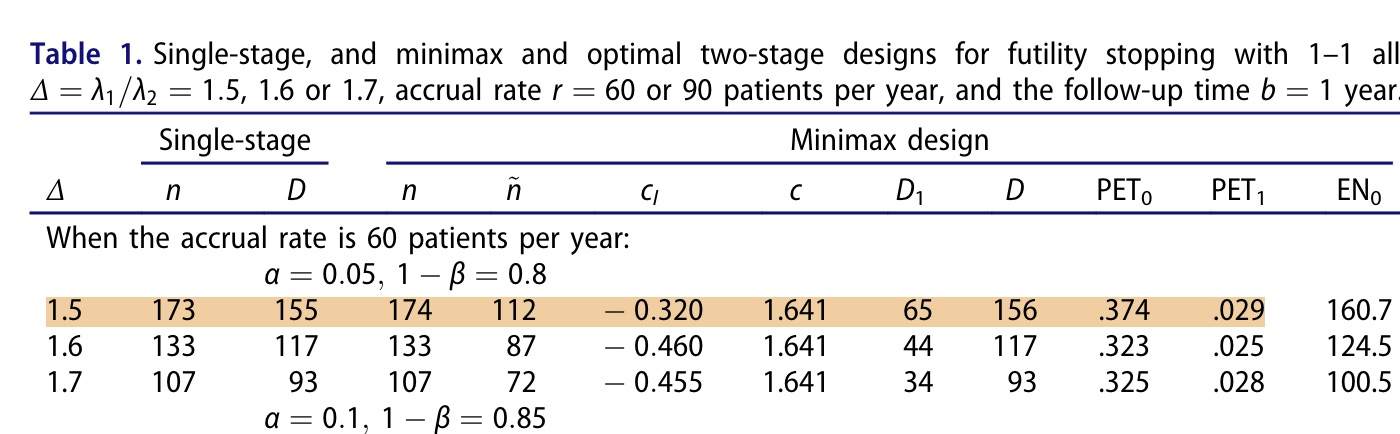

In [60]:
display_jpeg(file='Jung(2017)_table_1.jpeg')

### Use my searching loop

In [59]:
find_m_logrank(m_low = -2, logrank_data = logrank_data, search_times = 5000, search_step = 0.001,
                tar_a1 = 0.62, tar_pow1_low = 0.2, tar_a2 = 0.05, sim_size = 10000)

m1,PET0,PET1,m2,alpha,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.317,0.3806,0.0285,1.646,0.0498,0.8014


## Corresponding one stage log rank test (Interim $\tau = 0$) Jung (2017)

### <span style="color:yellow"> 1. Under NPH, should 2 stages log rank test be less powerful than one stage?????
### 2. Under PH, we can find a proper critical value to make 2 stages power ~ single stage 
### <span style="color:yellow">This conclusion is true when stopping for both superiority and futility or for futility only.
### overall $\textcolor{lightgreen}{\alpha = P(\frac{W_1}{\sigma_1}>C_u|H_0) + P(C_l<\frac{W_1}{\sigma_1}<C_u,\frac{W}{\sigma}>C|H_0)}$

------

# Test for different Interim Period

### Different Interim $\textcolor{yellow}{\tau}$
### 0.083 year is around a month. From 7 months interim to 16 months.

In [3]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
set.seed(2024)
n <- 51  # Fix total sample size

diff_interim_result <- foreach(k = 1:10, .combine = 'rbind',.packages = 'foreach') %dopar% {

    interim <- 0.5 + 0.083 * k 
    # Generate new data under each interim since the truncation is different. 
    # Interim sur time and fin sur time are merged in one dataset
    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)        

    rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim,sim_size = sim_size)
    rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim,sim_size = sim_size)
    rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = 2,sim_size = sim_size)
    rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = 2,sim_size = sim_size)
    rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

    # Find and record the most m t combination
    result <- find_m_t_RMST(m_low = -2, t_low = 0, t_up = 1, rmst_data = rmst_data, search_times = 300, 
                       search_step = 0.01, tar_a1 = 0.75, tar_pow1_low = 0.2, tar_a2 = 0.1, sim_size = 10000)

    if (is.null(result)) {
        return(data.frame(m1 = NA, t1 = NA, PET0 = NA, PET1 = NA, m2 = NA, t2 = NA,
                         alpha = NA, Power = NA ))
    }
    return(result)
   
}

In [4]:
diff_interim_result$"interim_month" <- 7:16
diff_interim_result

m1,t1,PET0,PET1,m2,t2,alpha,Power,interim_month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
-0.10,0.2966667,0.2506,0.0519,-0.14,0.6933333,0.0991,0.9406,7
-0.17,0.3300000,0.2511,0.0361,-0.09,0.6933333,0.0968,0.9543,8
-0.12,0.3500000,0.2503,0.0247,-0.08,0.6933333,0.0959,0.9656,9
-0.13,0.3733333,0.2551,0.0150,-0.06,0.6933333,0.0993,0.9752,10
-0.18,0.3966667,0.2508,0.0120,-0.09,0.6933333,0.0999,0.9770,11
-0.17,0.4133333,0.2502,0.0085,-0.06,0.6933333,0.0965,0.9830,12
-0.24,0.4300000,0.2501,0.0062,-0.08,0.6966667,0.0986,0.9830,13
-0.18,0.4433333,0.2528,0.0041,-0.09,0.6933333,0.0995,0.9851,14
-0.22,0.4566667,0.2529,0.0032,-0.10,0.6933333,0.0978,0.9862,15


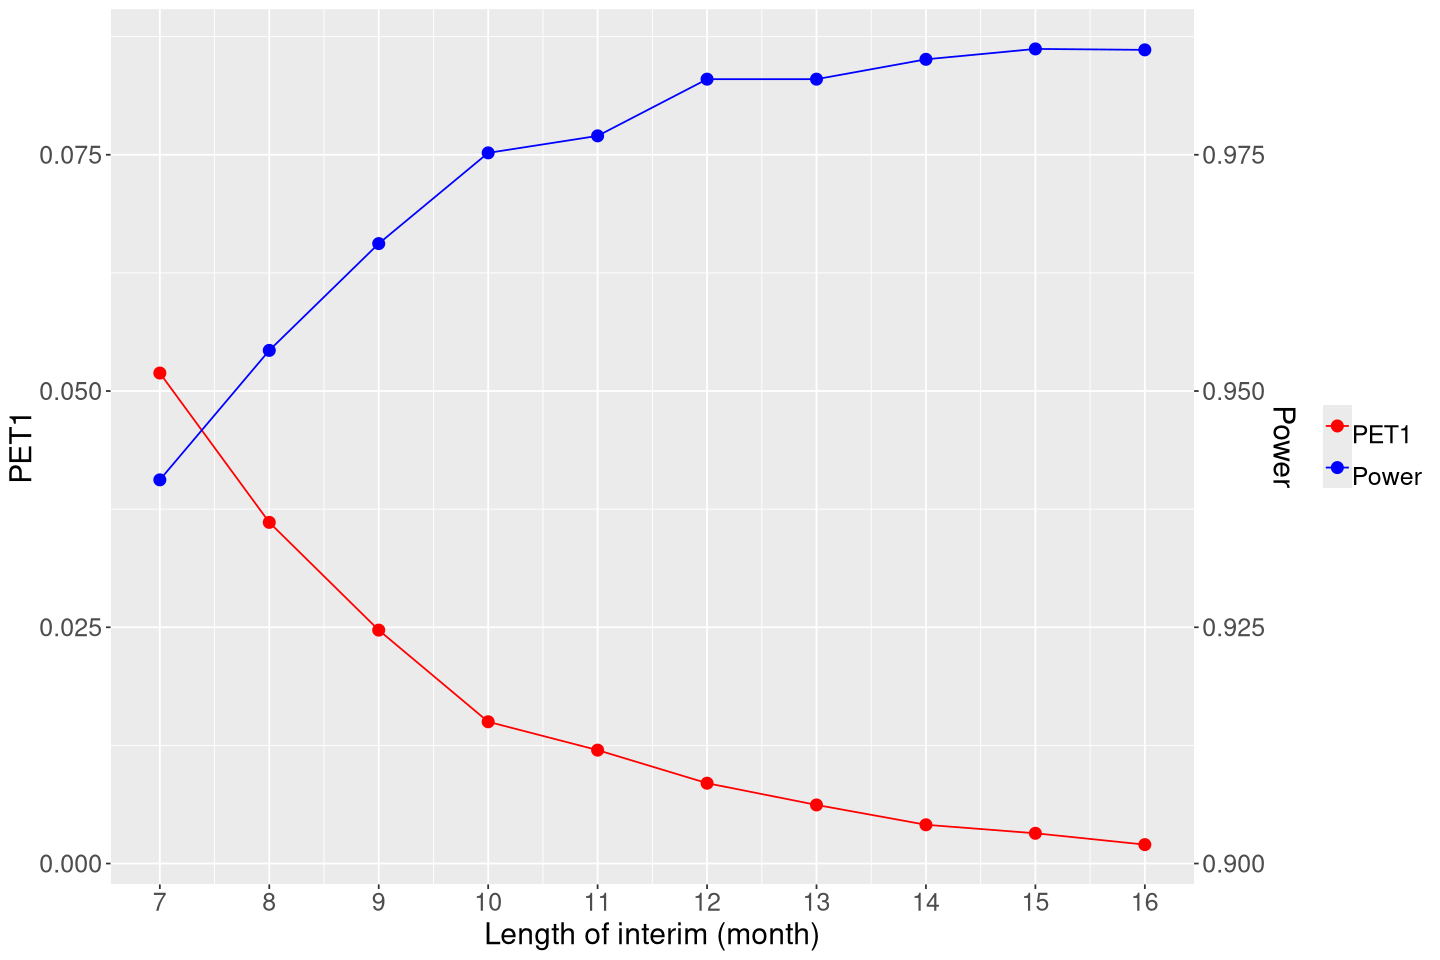

In [5]:
df <- diff_interim_result
options(repr.plot.width = 12, repr.plot.height = 8)

plot_n1 <- ggplot(df) +

  geom_point(data = df, aes(x = interim_month, y = PET1, color = "PET1") ,size = 3) +
  geom_point(data = df, aes(x = interim_month, y = Power - 0.9, color = "Power") ,size = 3) +
  geom_line(data = df, aes(x = interim_month, y = PET1, color = "PET1")) +
  geom_line(data = df, aes(x = interim_month, y = Power - 0.9, color = "Power")) +
  scale_x_continuous(breaks = 7:16 ) +
  scale_y_continuous(name = "PET1", sec.axis = sec_axis(~ . + 0.9, name = "Power")) +
  scale_color_manual("Variable", values = c("PET1" = "red", "Power" = "blue")) +
  theme(legend.title = element_blank(),
         axis.title = element_text(size = 18, margin = margin(t = 20)),
         axis.text = element_text(size = 15,margin = margin(t = 10)),
         legend.text = element_text(size = 15,margin = margin(t = 10))) +
   guides(color = guide_legend(title = "Scales"))+
   labs(x = "Length of interim (month)", y = "PET1")

plot_n1

-------